## Function

In [1]:
import json
import glob
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as pyplot

RUNS = []
for file in glob.glob("dumped-results/*.json"):
    with open(file) as f:
        data = json.load(f)
        c = list(data.keys())[0]
    RUNS.append({"corpus": c.split("--")[0], "model": c.split("--")[-1], **data[c]})
  
SORT_BY = "fscore-positive"
    
df = pd.DataFrame(RUNS)
filtered = df[
    ["corpus", "model", "fscore", "fscore-positive", "recall-positive", "precision-positive"]
].sort_values(by=SORT_BY)
def whatisenriched(val):
    if "LinearEnriched" in val:
        return "Linear"
    if "EnriLSTM" in val:
        return "LSTM"
    if "EnriAttention" in val:
        return "Attention"
    return ""
def whatismsd(val):
    if "AggloMSD" in val:
        return "Agglo."
    if "NoMorph" in val:
        return ""
    return "Split"
def whatisencoder(val):
    if "EnriLSTM" in val:
        return "LSTM"
    if "EnriAttention" in val:
        return "Attention"
    if "HAN" in val:
        return "HAN"
    if "HAN" in val:
        return "HAN"
    if "AttentPool" in val:
        return "AttentPool"
    return ""

def whatmetadata(val):
    enriched = whatisenriched(val)
    if "Metatoks" in val:
        return "Tokens"
    if not enriched:
        return ""
    if "NoAuthorCitation" in val:
        return "Form,Century"
    if "NoAuthor" in val:
        return "Form,Century,Citation"
    return "All"
    
def whatmodel(val):
    if "FastText" in val:
        return "FastText"
    elif "Pretrained" in val:
        return "Word2Vec"
    elif "Bert" in val:
        return "Bert"
    return ""

def hidden(val):
    if "128" in val:
        return "256"
    return "128"

filtered["Enriched"] = [whatisenriched(val) for val in filtered["model"]]
filtered["MSD"] = [whatismsd(val) for val in filtered["model"]]
filtered["Encoder"] = [whatisencoder(val) for val in filtered["model"]]
filtered["Metadata"] = [whatmetadata(val) for val in filtered["model"]]
filtered["Pretrained"] = [whatmodel(val) for val in filtered["model"]]
# filtered["Bert"] = filtered["model"].str.contains("Bert")
filtered["Size"] = [hidden(val) for val in filtered["corpus"]]
filtered["Method"] = ["Siamese" if "siamese" in val else "Linear" for val in filtered["corpus"]]


def plot(ax, df, cols_to_plot, subtitle):
    df.boxplot(cols_to_plot, ax=ax)
    ax.set_xticklabels([col.replace("-positive", "") for col in cols_to_plot])
    ax.set_title(subtitle)

def get(filt, best_only=5, cols_to_plot=["fscore-positive", "precision-positive", "recall-positive"]):
    model = filtered[filt][[col for col in filtered.columns if col != "corpus"]]
    bests = model
    fig, (ax1, ax2, ax3) = pyplot.subplots(1, 3, dpi=300, sharey=True, figsize=(8, 3))
    plot(cols_to_plot=cols_to_plot, ax=ax1, df=bests[(
        model["Metadata"] == "All"
    ) | (
        model["Metadata"] == "Form,Century,Citation"
    )], subtitle="Avec toutes les métadonnées")
    if best_only:
        bests = bests.nlargest(best_only, SORT_BY)
    display(HTML(bests.to_html()))
    display(HTML("<h3>Without all metadata</h3>"))
    #filtered[(filtered["Metadata"] != "All") & (filtered["Metadata"] != "Form,Century,Citation")]
    sub = model[model["Metadata"] == "Form,Century"]
    plot(cols_to_plot=cols_to_plot, ax=ax2, df=sub, subtitle="Avec siècle et forme uniquement")
    
    
    sub2 = model[model["Metadata"] == ""]
    plot(cols_to_plot=cols_to_plot, ax=ax3, df=sub2, subtitle="Aucune métadonnée")
    if best_only:
        sub = sub.nlargest(best_only, SORT_BY)
    display(HTML(
        sub.to_html()
    ))
    return [
        f"Enri{row.Enriched or 'No'}-{row.MSD or 'NoMSD'}-{row.Encoder}{row.Size}-{row.Metadata or 'NoMetadata'}-{row.Pretrained or 'NoPretrain'}-{row.Method}"
        for _, row in sub.iterrows()
    ]

bests = {}

print(len(filtered[(filtered.corpus.str.contains("model")) & (filtered.Method == "Linear")].model.unique()))

56


<AxesSubplot:xlabel='Score en catégorie positive', ylabel='Valeur (en %)'>

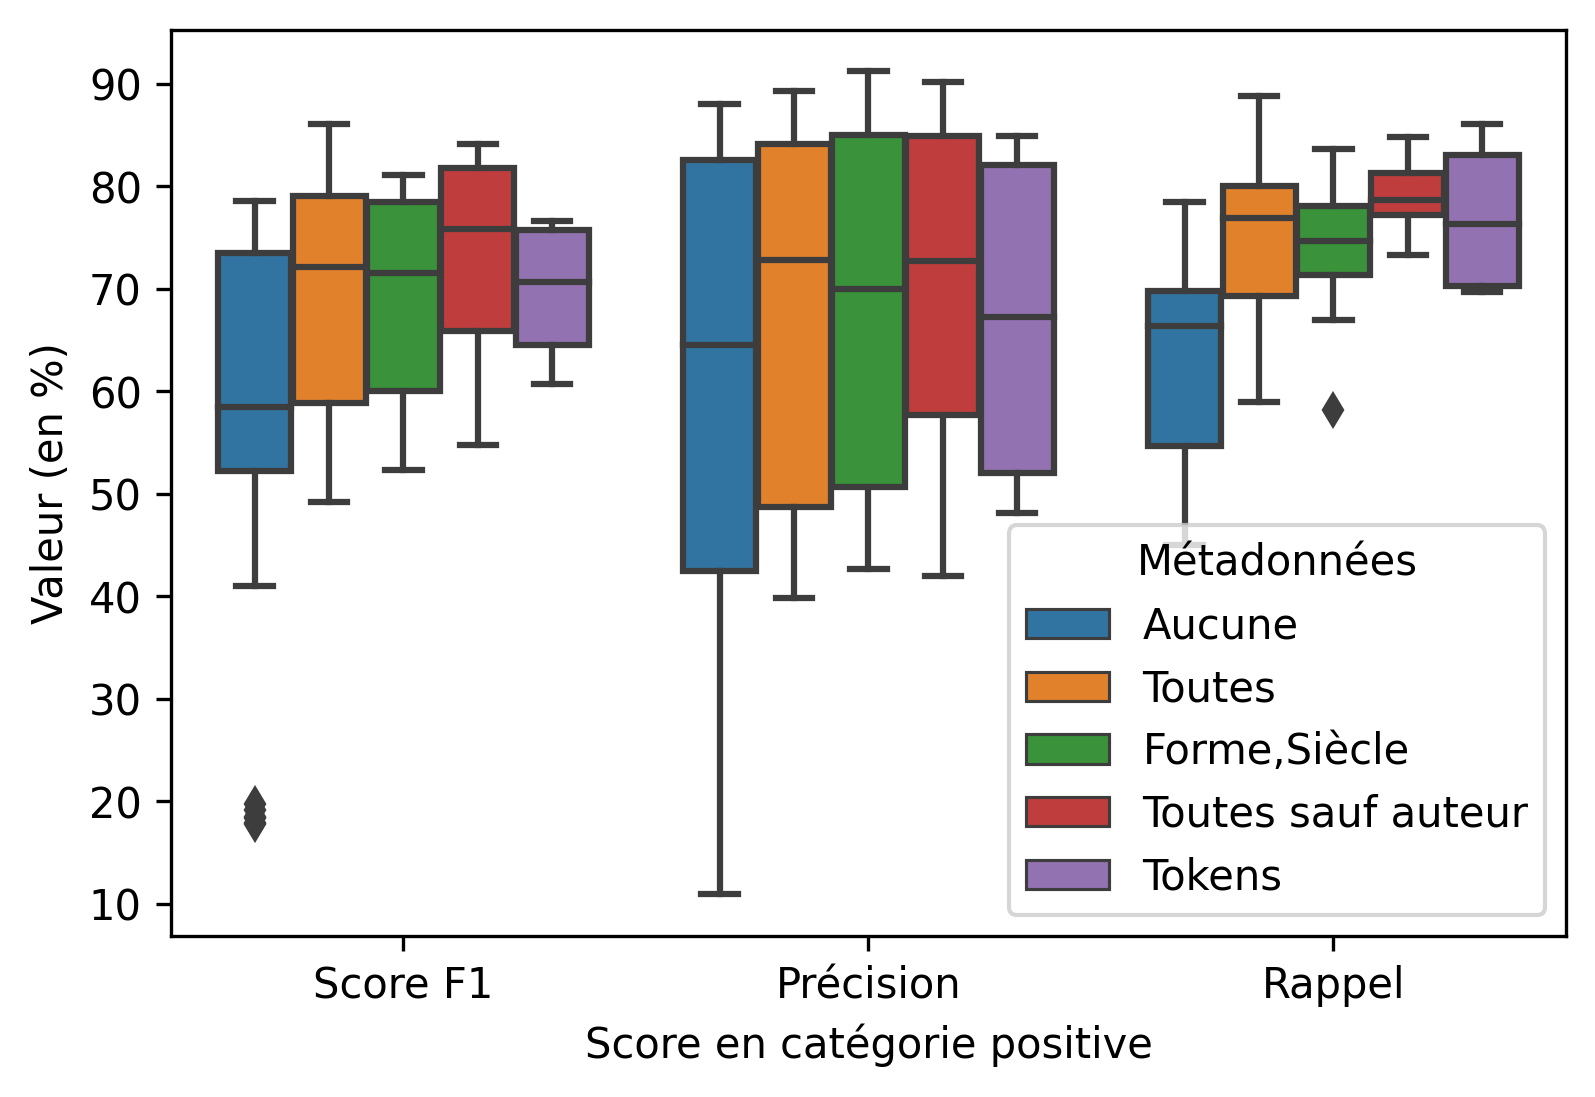

In [2]:
import seaborn as sns

cols = ["fscore-positive", "precision-positive", "recall-positive"]
cop = filtered[filtered["corpus"].str.contains("model")][cols+["Metadata"]]
cop.loc[cop.Metadata == "", "Metadata"] = "Aucune"
cop.loc[cop.Metadata == "All", "Metadata"] = "Toutes"
cop.loc[cop.Metadata == "Form,Century,Citation", "Metadata"] = "Toutes sauf auteur"
cop.loc[cop.Metadata == "Form,Century", "Metadata"] = "Forme,Siècle"


newdf = []
for idx, row  in cop.iterrows():
    for col, buty in [
        ("fscore-positive", "Score F1"),
        ("precision-positive", "Précision"),
        ("recall-positive", "Rappel")]:
        newdf.append({"Valeur (en %)": row[col]*100, "Score en catégorie positive": buty, "Métadonnées": row.Metadata})

import matplotlib.pyplot as plt

fig = plt.figure(dpi=300)
sns.boxplot(data=pd.DataFrame(newdf), hue="Métadonnées", x="Score en catégorie positive", y="Valeur (en %)")

## Main models

,model,fscore,fscore-positive,recall-positive,precision-positive,Enriched,MSD,Encoder,Metadata,Pretrained,Size,Method
54,LinearVanilla-NoMorph-HAN-LinearEnriched-Pretrained,0.923120,0.860511,0.872510,0.848837,Linear,,HAN,All,Word2Vec,128,Linear
242,LinearVanillaAggloMSD-HAN-LinearEnriched-Pretrained,0.914881,0.844538,0.800797,0.893333,Linear,Agglo.,HAN,All,Word2Vec,128,Linear
23,model-128-LinearVanilla-NoMorph-HAN-LinearEnriched-Pretrained,0.912277,0.841509,0.888446,0.799283,Linear,,HAN,All,Word2Vec,256,Linear
206,LinearVanillaAggloMSD-HAN-LinearEnriched-Pretrained-NoAuthor,0.912917,0.841237,0.812749,0.871795,Linear,Agglo.,HAN,"Form,Century,Citation",Word2Vec,128,Linear
274,model-128-LinearVanillaAggloMSD-HAN-LinearEnriched-Pretrained-NoAuthor,0.911261,0.837895,0.792829,0.888393,Linear,Agglo.,HAN,"Form,Century,Citation",Word2Vec,256,Linear
269,LinearVanillaAggloMSD-EnriLSTM-Pretrained,0.908608,0.832981,0.784861,0.887387,LSTM,Agglo.,LSTM,All,Word2Vec,128,Linear
117,LinearVanilla-NoMorph-HAN-LinearEnriched-Pretrained-NoAuthor,0.907306,0.831683,0.836653,0.826772,Linear,,HAN,"Form,Century,Citation",Word2Vec,128,Linear
130,model-128-LinearVanilla-NoMorph-HAN-LinearEnriched-Pretrained-NoAuthor,0.901824,0.820833,0.784861,0.860262,Linear,,HAN,"Form,Century,Citation",Word2Vec,256,Linear
176,model-128-LinearVanillaAggloMSD-HAN-LinearEnriched-Pretrained,0.900291,0.818182,0.788845,0.849785,Linear,Agglo.,HAN,All,Word2Vec,256,Linear
125,model-128-LinearVanilla-NoMorph-EnriLSTM-Pretrained-NoAuthor,0.899346,0.816495,0.788845,0.846154,LSTM,,LSTM,"Form,Century,Citation",Word2Vec,256,Linear


,model,fscore,fscore-positive,recall-positive,precision-positive,Enriched,MSD,Encoder,Metadata,Pretrained,Size,Method
42,model-128-LinearVanillaAggloMSD-EnriLSTM-Pretrained-NoAuthorCitation,0.896311,0.810811,0.776892,0.847826,LSTM,Agglo.,LSTM,"Form,Century",Word2Vec,256,Linear
73,model-128-LinearVanilla-NoMorph-HAN-LinearEnriched-Pretrained-NoAuthorCitation,0.890618,0.799107,0.713147,0.908629,Linear,,HAN,"Form,Century",Word2Vec,256,Linear
34,LinearVanillaAggloMSD-EnriLSTM-Pretrained-NoAuthorCitation,0.890171,0.798206,0.709163,0.912821,LSTM,Agglo.,LSTM,"Form,Century",Word2Vec,128,Linear
128,LinearVanilla-NoMorph-EnriLSTM-Pretrained-NoAuthorCitation,0.888640,0.795556,0.713147,0.899498,LSTM,,LSTM,"Form,Century",Word2Vec,128,Linear
167,LinearVanillaAggloMSD-HAN-LinearEnriched-Pretrained-NoAuthorCitation,0.886770,0.793319,0.756972,0.833333,Linear,Agglo.,HAN,"Form,Century",Word2Vec,128,Linear
66,model-128-LinearVanillaAggloMSD-HAN-LinearEnriched-Pretrained-NoAuthorCitation,0.880806,0.782609,0.752988,0.814655,Linear,Agglo.,HAN,"Form,Century",Word2Vec,256,Linear
10,LinearVanilla-NoMorph-HAN-LinearEnriched-Pretrained-NoAuthorCitation,0.878956,0.777778,0.697211,0.879397,Linear,,HAN,"Form,Century",Word2Vec,128,Linear
48,model-128-LinearVanilla-NoMorph-EnriLSTM-Pretrained-NoAuthorCitation,0.878049,0.776824,0.721116,0.841860,LSTM,,LSTM,"Form,Century",Word2Vec,256,Linear
271,model-128-LinearVanilla-NoMorph-EnriLSTM-Pretrained-NoAuthorCitation-FastText,0.876709,0.775000,0.741036,0.812227,LSTM,,LSTM,"Form,Century",FastText,256,Linear
201,LinearVanilla-NoMorph-EnriLSTM-Pretrained-NoAuthorCitation-FastText,0.864820,0.751678,0.669323,0.857143,LSTM,,LSTM,"Form,Century",FastText,128,Linear


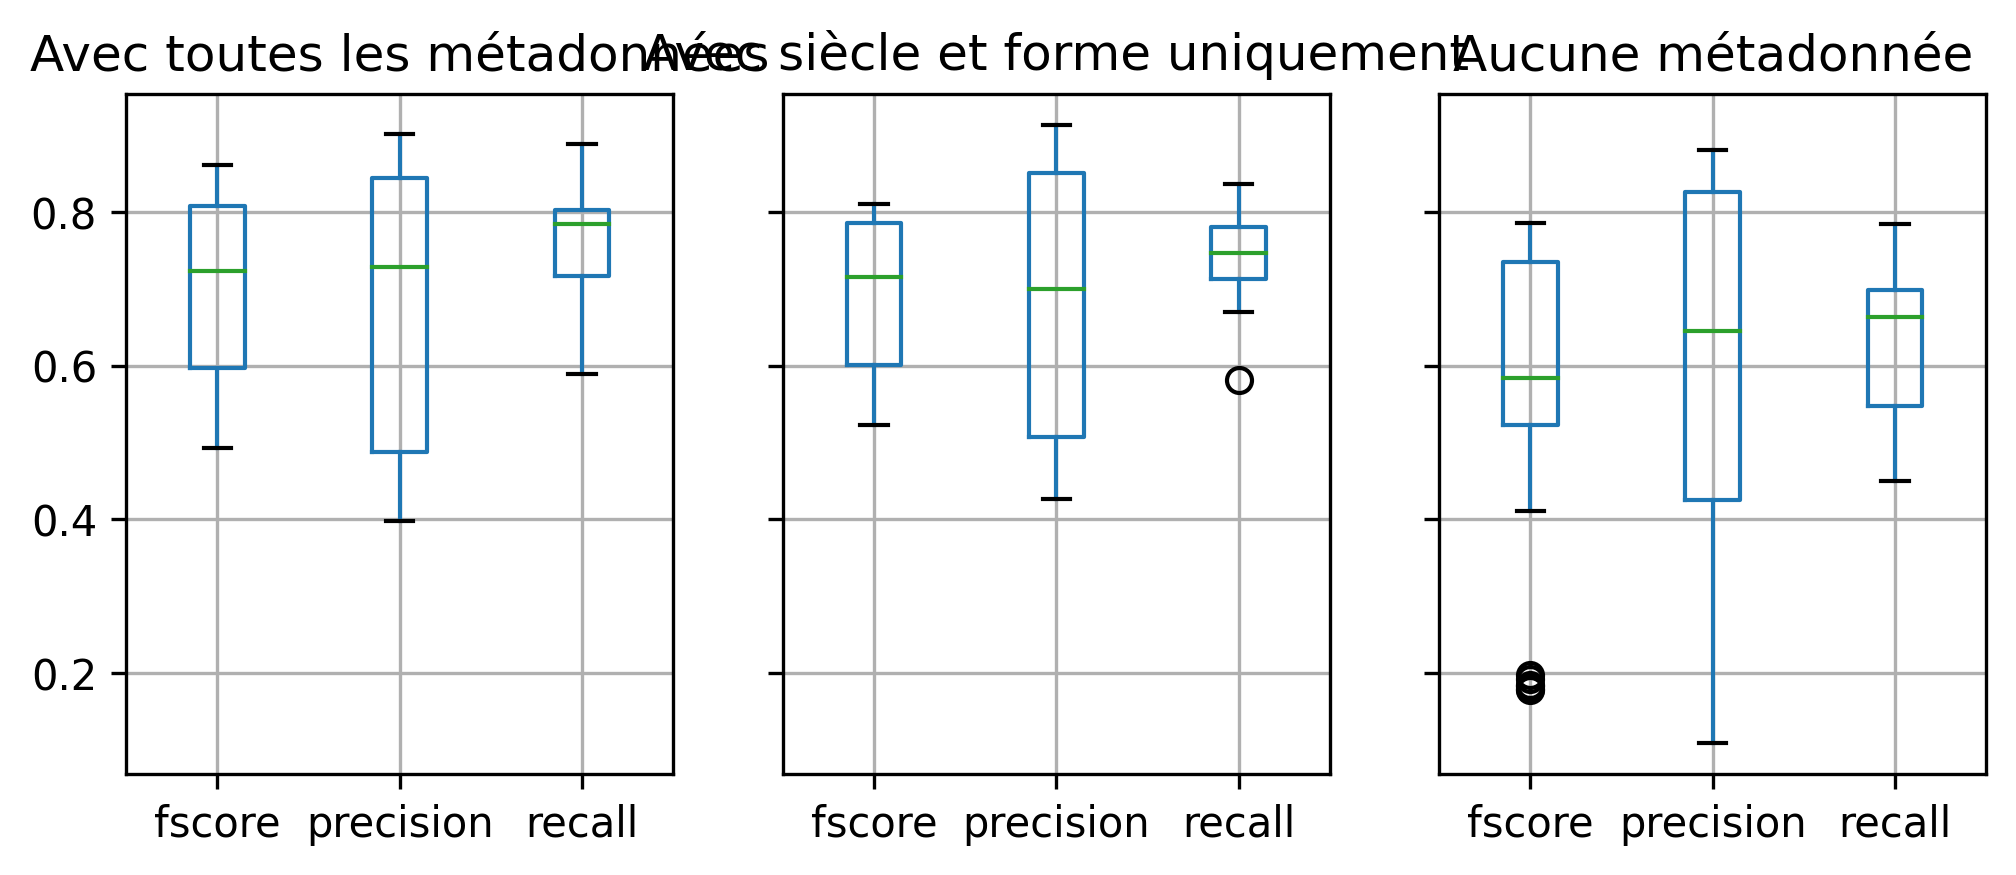

In [3]:
bests["main"] = set(get(filtered["corpus"].str.contains("model"), best_only=112))

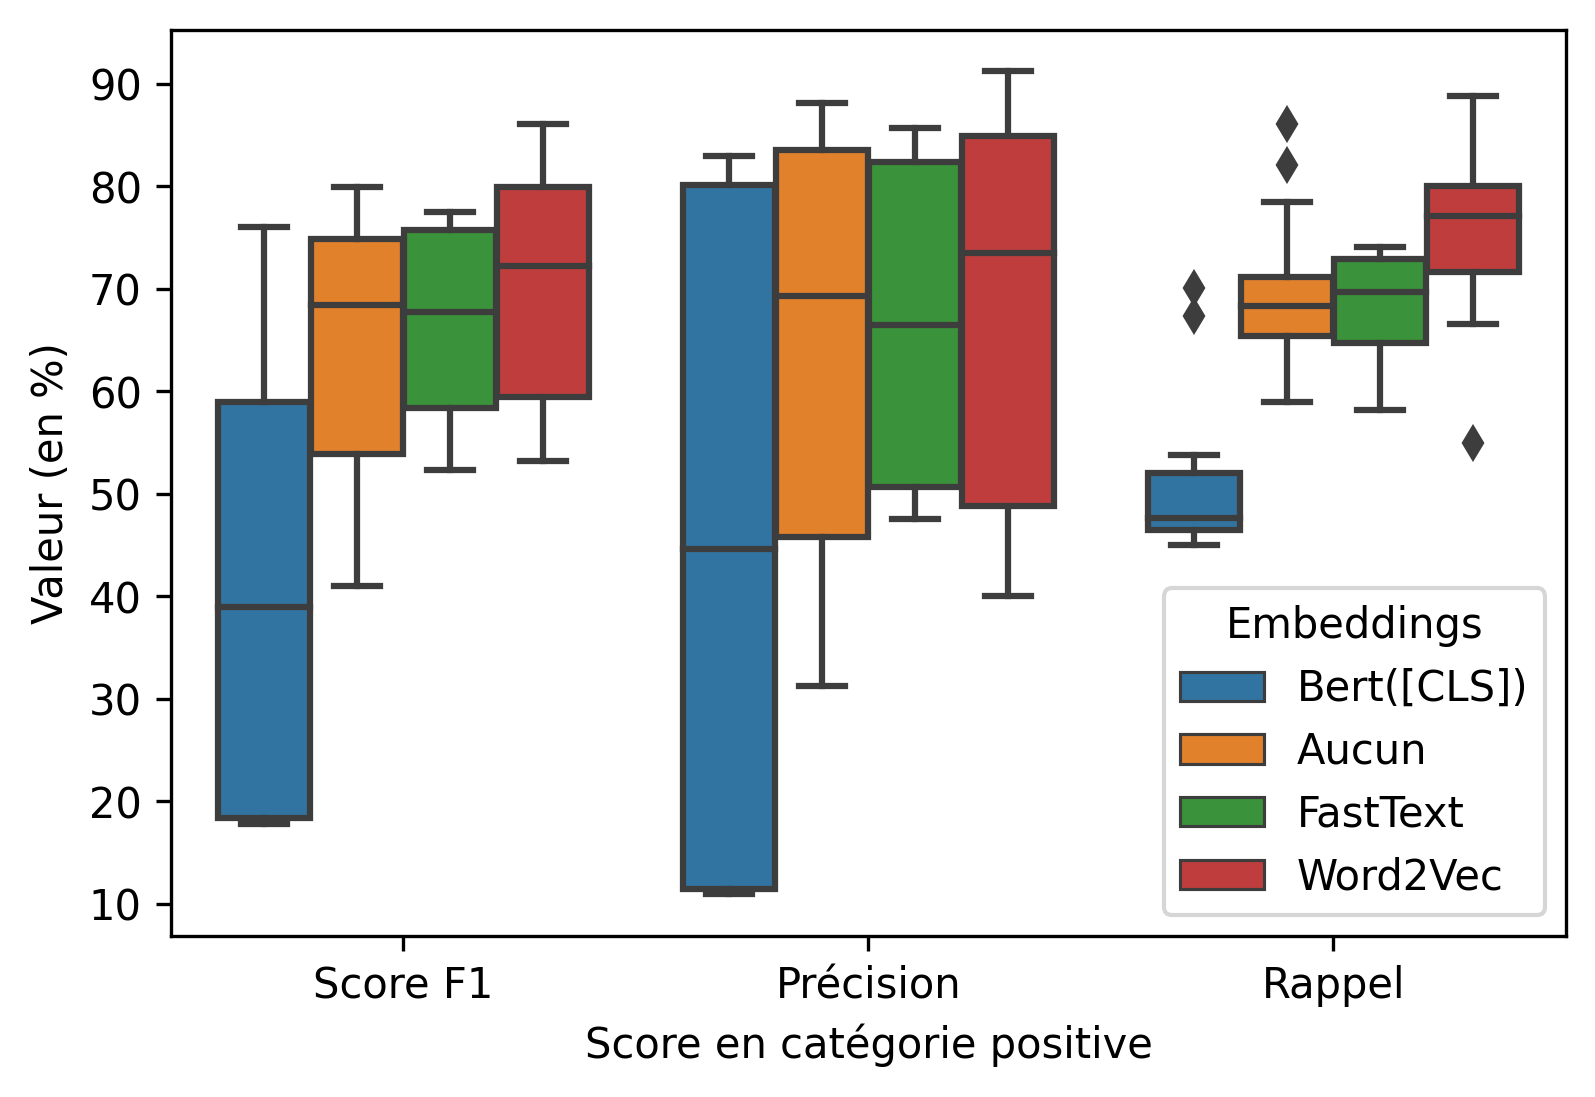

In [4]:
import seaborn as sns

cols = ["fscore-positive", "precision-positive", "recall-positive"]
cop = filtered[filtered["corpus"].str.contains("model")][cols+["Pretrained"]]


newdf = []
for idx, row  in cop.iterrows():
    for col, buty in [
        ("fscore-positive", "Score F1"),
        ("precision-positive", "Précision"),
        ("recall-positive", "Rappel")]:
        newdf.append({
            "Valeur (en %)": row[col]*100,
            "Score en catégorie positive": buty,
            "Embeddings": row["Pretrained"].replace("Bert", "Bert([CLS])") or "Aucun"
        })

import matplotlib.pyplot as plt

fig = plt.figure(dpi=300)
sns.boxplot(data=pd.DataFrame(newdf), hue="Embeddings", x="Score en catégorie positive", y="Valeur (en %)")

pd.DataFrame(newdf).to_csv("embeddings_scores.csv")

<AxesSubplot:xlabel='Score en catégorie positive', ylabel='Valeur (en %)'>

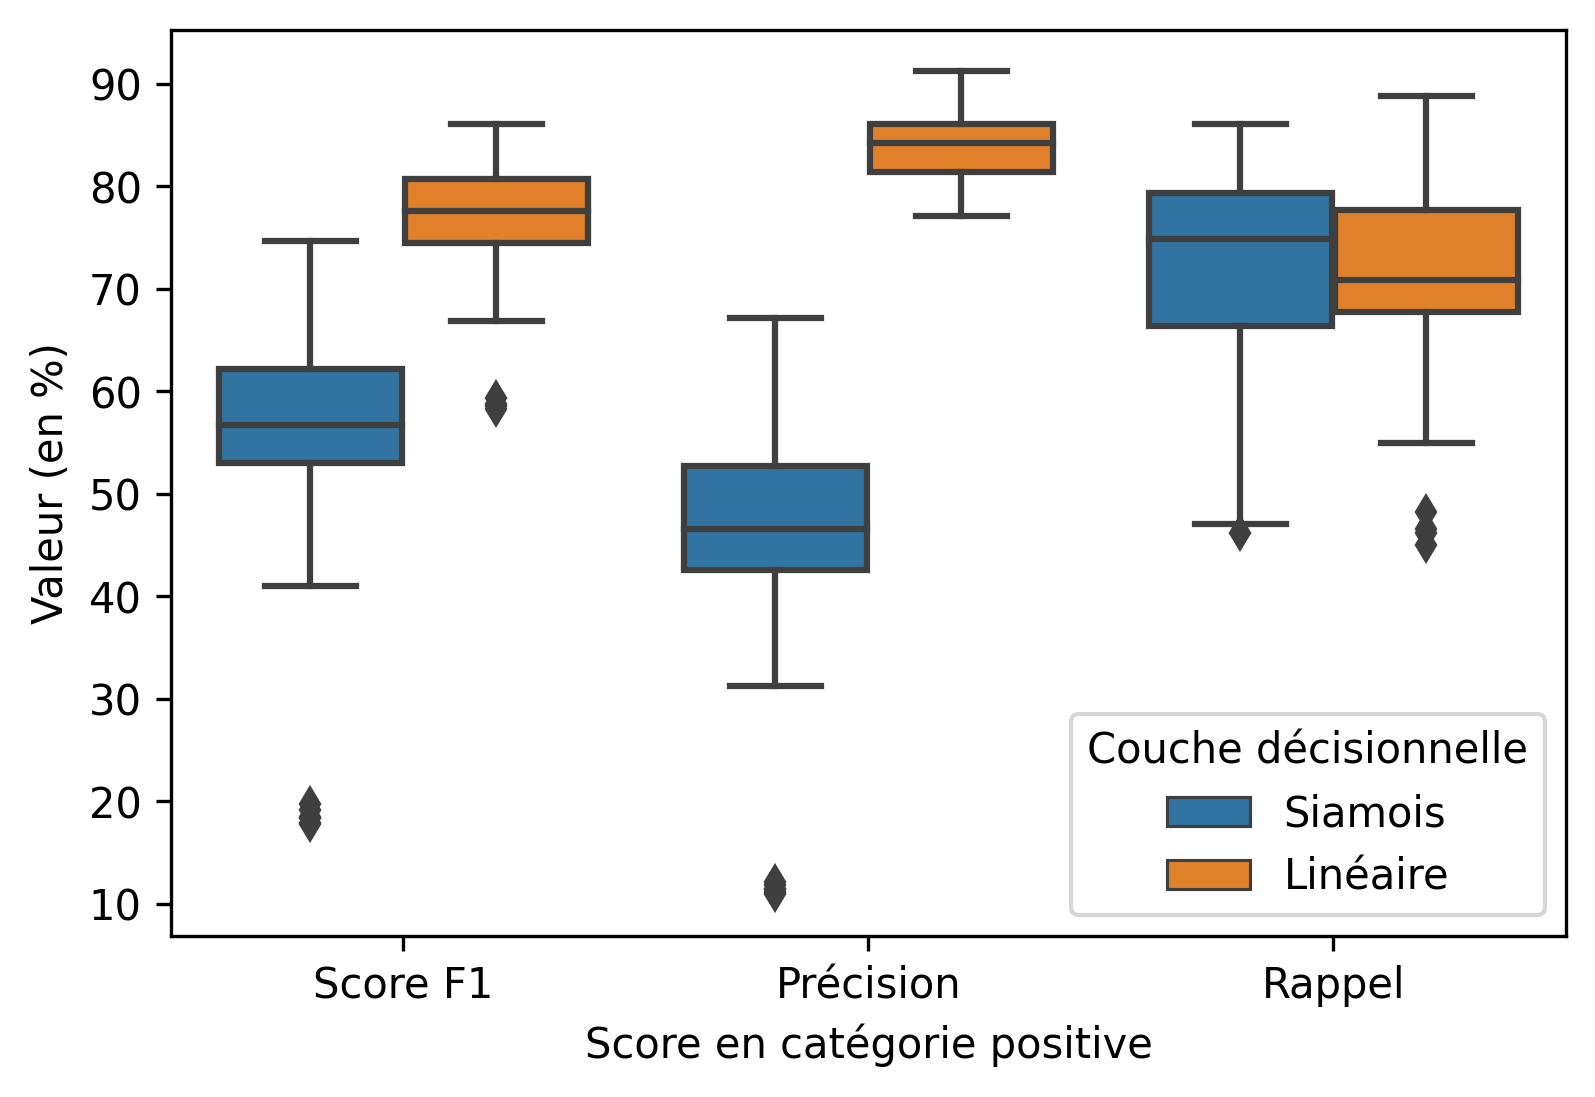

In [13]:
import seaborn as sns

cols = ["fscore-positive", "precision-positive", "recall-positive"]
cop = filtered[filtered["corpus"].str.contains("model")][cols+["Method"]]


newdf = []
for idx, row  in cop.iterrows():
    for col, buty in [
        ("fscore-positive", "Score F1"),
        ("precision-positive", "Précision"),
        ("recall-positive", "Rappel")]:
        newdf.append({
            "Valeur (en %)": row[col]*100,
            "Score en catégorie positive": buty,
            "Couche décisionnelle": "Siamois" if row["Method"] == "Siamese" else "Linéaire"
        })

import matplotlib.pyplot as plt

fig = plt.figure(dpi=300)
sns.boxplot(data=pd.DataFrame(newdf), hue="Couche décisionnelle", x="Score en catégorie positive", y="Valeur (en %)")


### Décompte


In [6]:
filtered[filtered["corpus"].str.contains("model")].Method.value_counts()

Siamese    56
Linear     56
Name: Method, dtype: int64

### Regression

[Text(0, 0, 'Aucune'),
 Text(1, 0, 'Toutes'),
 Text(2, 0, 'Forme,Siècle'),
 Text(3, 0, 'Forme,Siècle,Structure'),
 Text(4, 0, 'Tokens')]

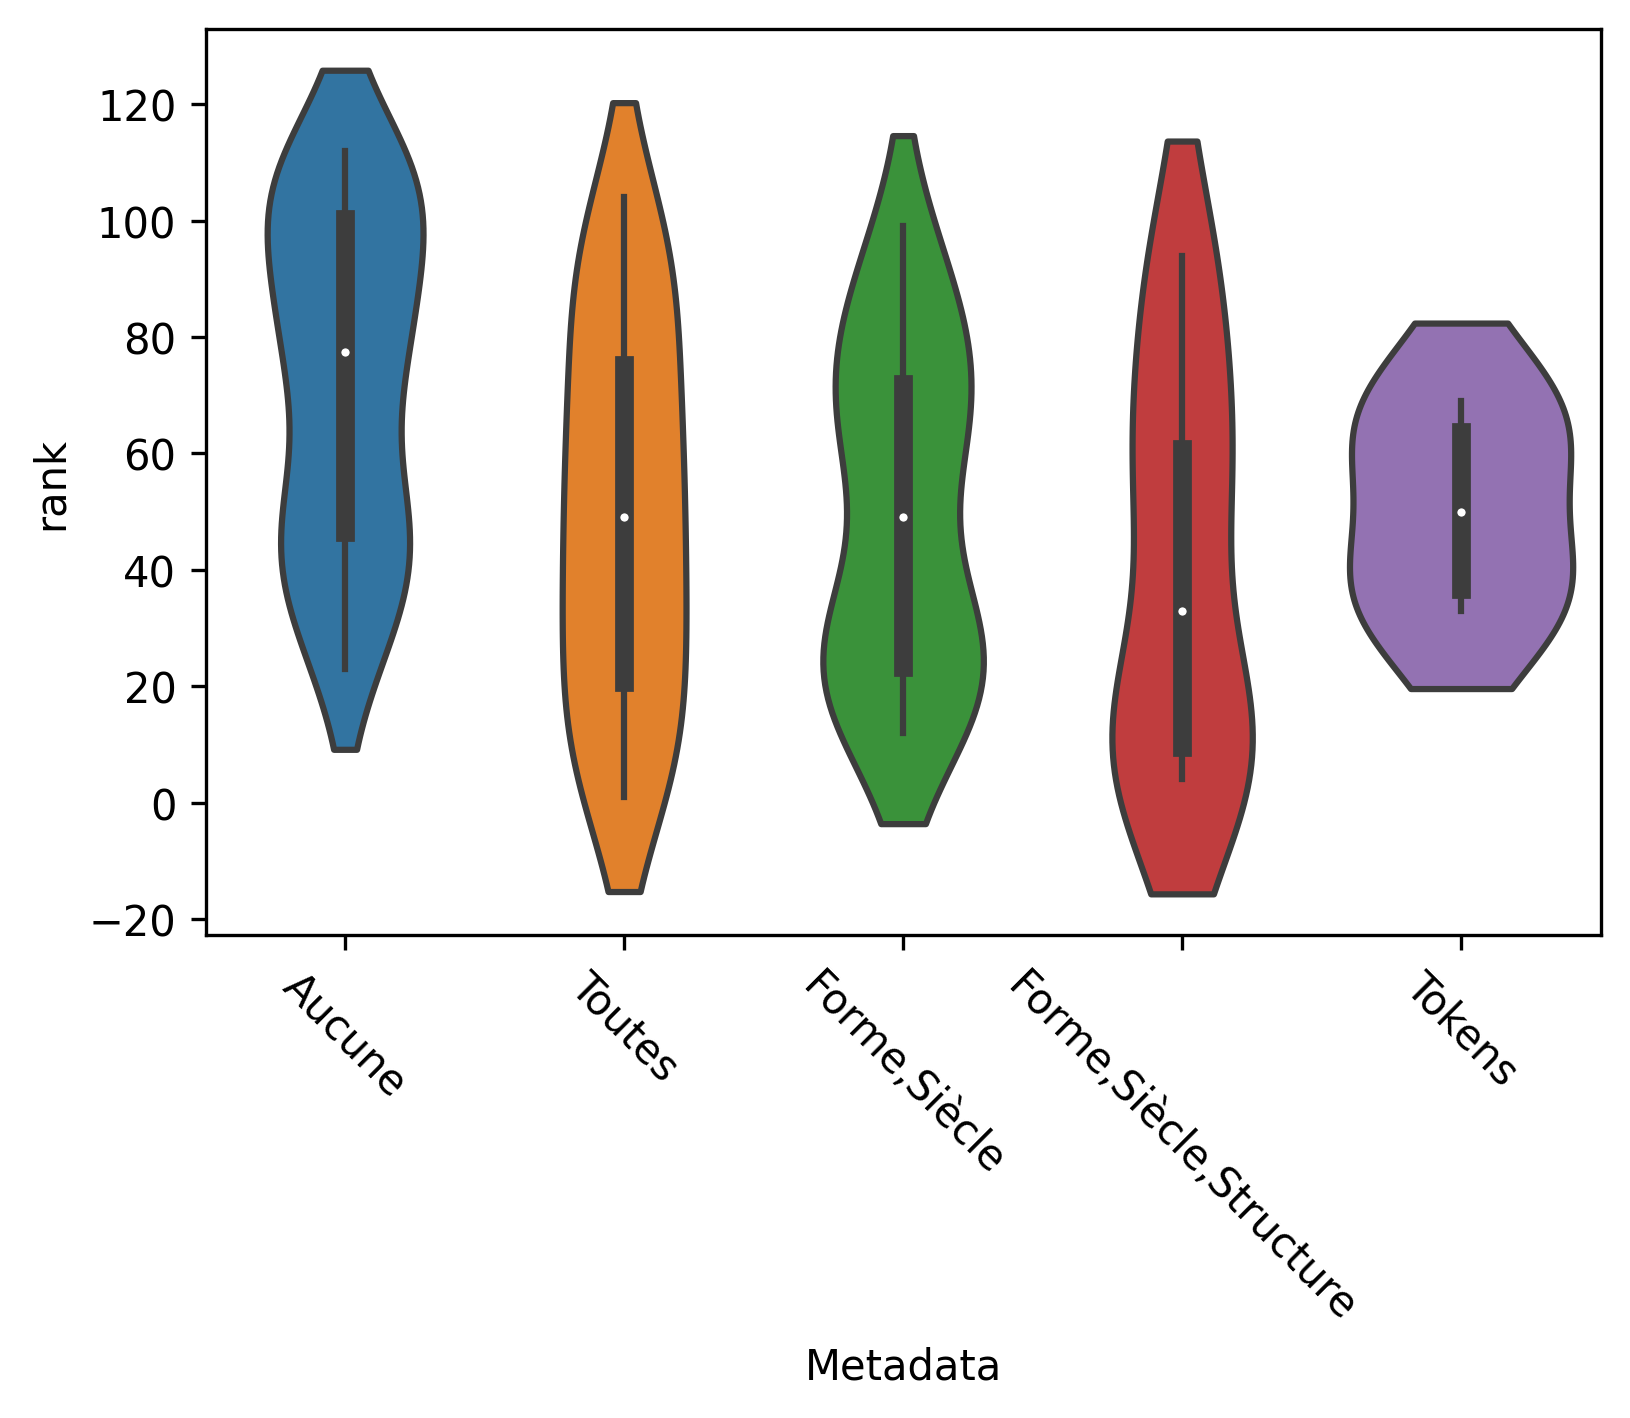

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

model = filtered[filtered["corpus"].str.contains("model")].copy()
model["rank"] = model["fscore-positive"].rank(method="max", ascending=False)
model.sort_values(by="fscore-positive")
fig = plt.figure(dpi=300)
ax = sns.violinplot(data=model, x="Metadata", y="rank", ax=plt.gca(), inner="box", cut=True)
plt.xticks(rotation = -45)
labels = {
        "": "Aucune",
        "All": "Toutes",
        "Form,Century": "Forme,Siècle",
        "Form,Century,Citation": "Forme,Siècle,Structure",
        "Tokens": "Tokens"
    }
ax.set_xticklabels([
    labels.get(x._text, x)
    for x in ax.get_xticklabels()
])

### Regression


In [8]:
filtered[filtered["corpus"].str.contains("model")].Metadata.value_counts()

                         40
All                      32
Form,Century             20
Form,Century,Citation    16
Tokens                    4
Name: Metadata, dtype: int64

## Metaphors

,model,fscore,fscore-positive,recall-positive,precision-positive,Enriched,MSD,Encoder,Metadata,Pretrained,Size,Method
91,LinearVanilla-LinearEnriched-Pretrained,0.804704,0.674623,0.522120,0.952972,Linear,Split,,All,Word2Vec,128,Linear
211,LinearVanillaAggloMSD-Metatoks-HAN,0.790073,0.648088,0.486145,0.971817,,Agglo.,HAN,Tokens,,256,Linear
119,LinearVanillaAggloMSD-HAN-LinearEnriched-Pretrained,0.778801,0.629402,0.473505,0.938343,Linear,Agglo.,HAN,All,Word2Vec,128,Linear
3,LinearVanilla-LinearEnriched-Pretrained,0.772501,0.616866,0.451629,0.972775,Linear,Split,,All,Word2Vec,256,Linear
35,LinearVanilla-NoMorph-EnriLSTM-Pretrained-NoAuthorCitation-FastText,0.767454,0.608782,0.448226,0.948560,LSTM,,LSTM,"Form,Century",FastText,256,Linear


,model,fscore,fscore-positive,recall-positive,precision-positive,Enriched,MSD,Encoder,Metadata,Pretrained,Size,Method
35,LinearVanilla-NoMorph-EnriLSTM-Pretrained-NoAuthorCitation-FastText,0.767454,0.608782,0.448226,0.948560,LSTM,,LSTM,"Form,Century",FastText,256,Linear
16,LinearVanilla-NoMorph-HAN-LinearEnriched-Pretrained-NoAuthorCitation,0.758284,0.593760,0.439475,0.914980,Linear,,HAN,"Form,Century",Word2Vec,128,Linear
140,LinearVanillaAggloMSD-EnriLSTM-Pretrained-NoAuthorCitation,0.750553,0.578574,0.416140,0.949002,LSTM,Agglo.,LSTM,"Form,Century",Word2Vec,256,Linear
191,LinearVanilla-NoMorph-EnriLSTM-Pretrained-NoAuthorCitation-FastText,0.741972,0.562800,0.398639,0.956826,LSTM,,LSTM,"Form,Century",FastText,128,Linear
208,LinearVanillaAggloMSD-EnriLSTM-Pretrained-NoAuthorCitation,0.741270,0.562181,0.401070,0.939636,LSTM,Agglo.,LSTM,"Form,Century",Word2Vec,128,Linear


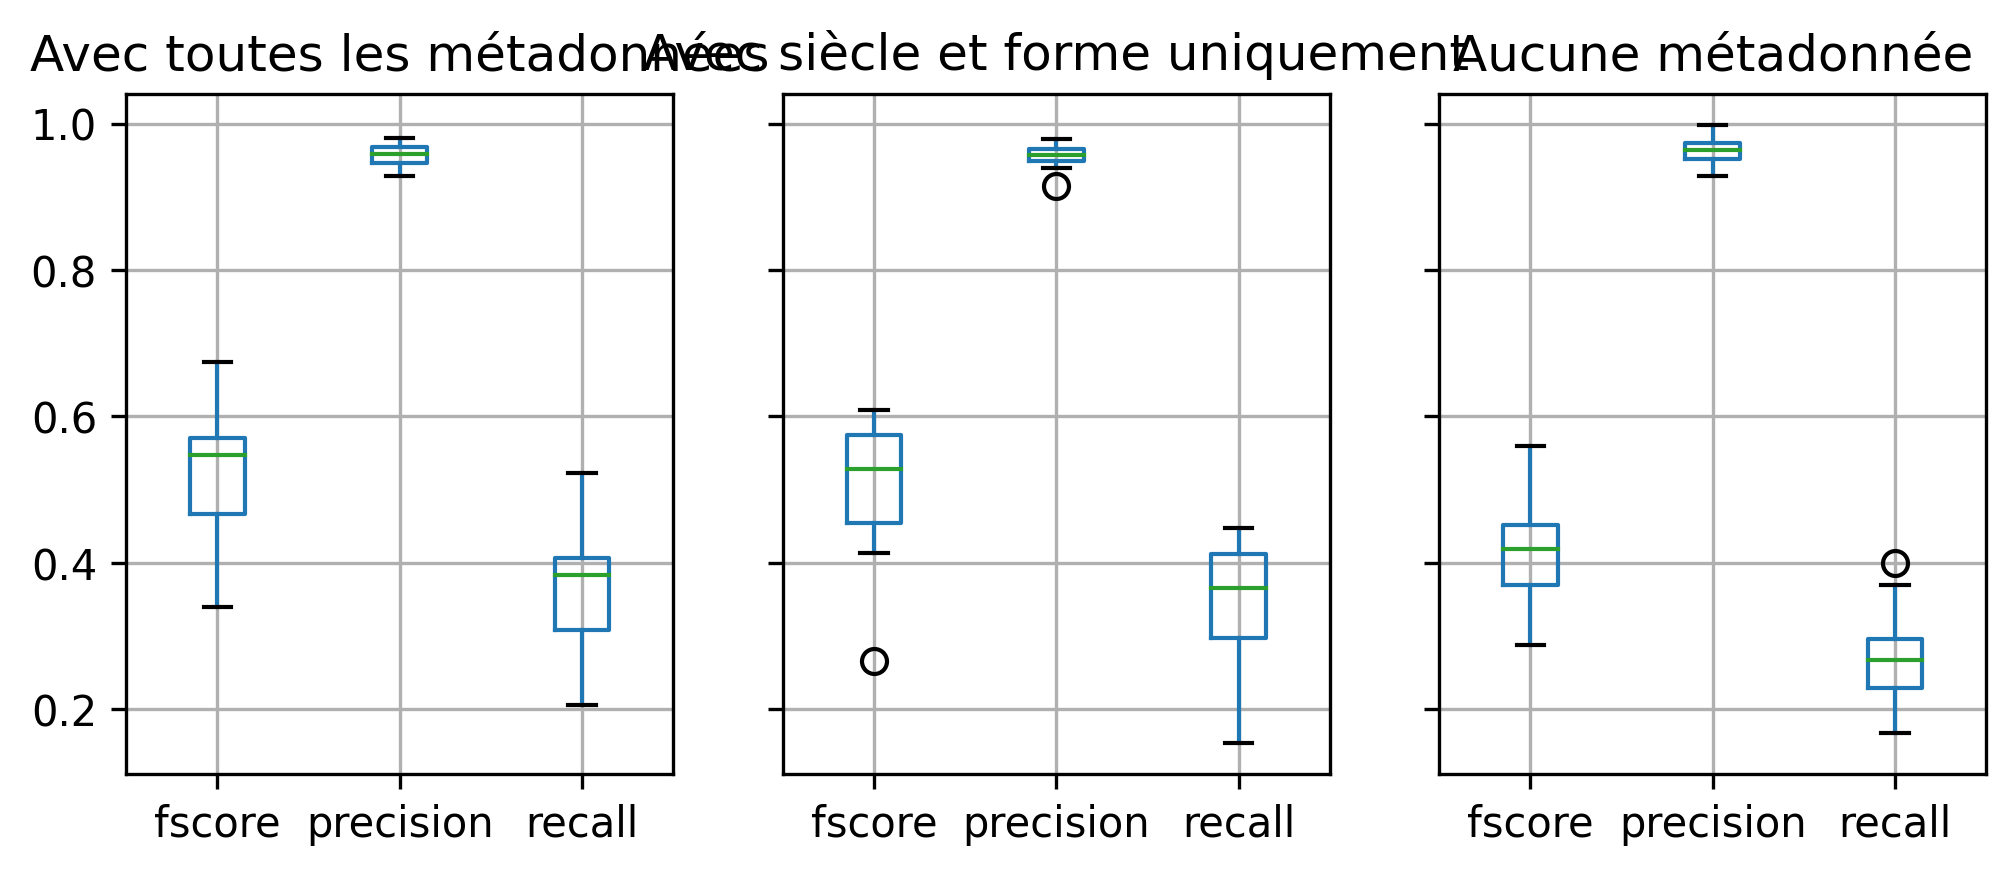

In [9]:
bests["metaphors"] = set(get((
    filtered["corpus"].str.contains("metaphors")
) & (
    ~filtered["corpus"].str.contains("inversed")
)))

## Not metaphors

,model,fscore,fscore-positive,recall-positive,precision-positive,Enriched,MSD,Encoder,Metadata,Pretrained,Size,Method
204,LinearVanillaAggloMSD-HAN-LinearEnriched-Pretrained,0.844578,0.708502,0.762527,0.661626,Linear,Agglo.,HAN,All,Word2Vec,256,Linear
159,LinearVanilla-NoMorph-HAN-LinearEnriched-Pretrained,0.845559,0.708046,0.671024,0.749392,Linear,,HAN,All,Word2Vec,256,Linear
278,LinearVanilla-LinearEnriched-Pretrained,0.842536,0.703899,0.727669,0.681633,Linear,Split,,All,Word2Vec,128,Linear
135,LinearVanillaAggloMSD-Metatoks-HAN,0.842496,0.702395,0.671024,0.736842,,Agglo.,HAN,Tokens,,256,Linear
275,LinearVanilla-LinearEnriched-Pretrained,0.840207,0.699580,0.725490,0.675456,Linear,Split,,All,Word2Vec,256,Linear


,model,fscore,fscore-positive,recall-positive,precision-positive,Enriched,MSD,Encoder,Metadata,Pretrained,Size,Method
13,LinearVanilla-NoMorph-EnriLSTM-Pretrained-NoAuthorCitation-FastText,0.830773,0.679860,0.636166,0.730000,LSTM,,LSTM,"Form,Century",FastText,256,Linear
160,LinearVanillaAggloMSD-HAN-LinearEnriched-Pretrained-NoAuthorCitation,0.821479,0.662909,0.640523,0.686916,Linear,Agglo.,HAN,"Form,Century",Word2Vec,128,Linear
202,LinearVanilla-NoMorph-HAN-LinearEnriched-Pretrained-NoAuthorCitation,0.820849,0.661290,0.625272,0.701711,Linear,,HAN,"Form,Century",Word2Vec,256,Linear
57,LinearVanilla-NoMorph-EnriLSTM-Pretrained-NoAuthorCitation,0.815629,0.650888,0.599129,0.712435,LSTM,,LSTM,"Form,Century",Word2Vec,128,Linear
41,LinearVanilla-NoMorph-EnriLSTM-Pretrained-NoAuthorCitation-FastText,0.813516,0.647919,0.627451,0.669767,LSTM,,LSTM,"Form,Century",FastText,128,Linear


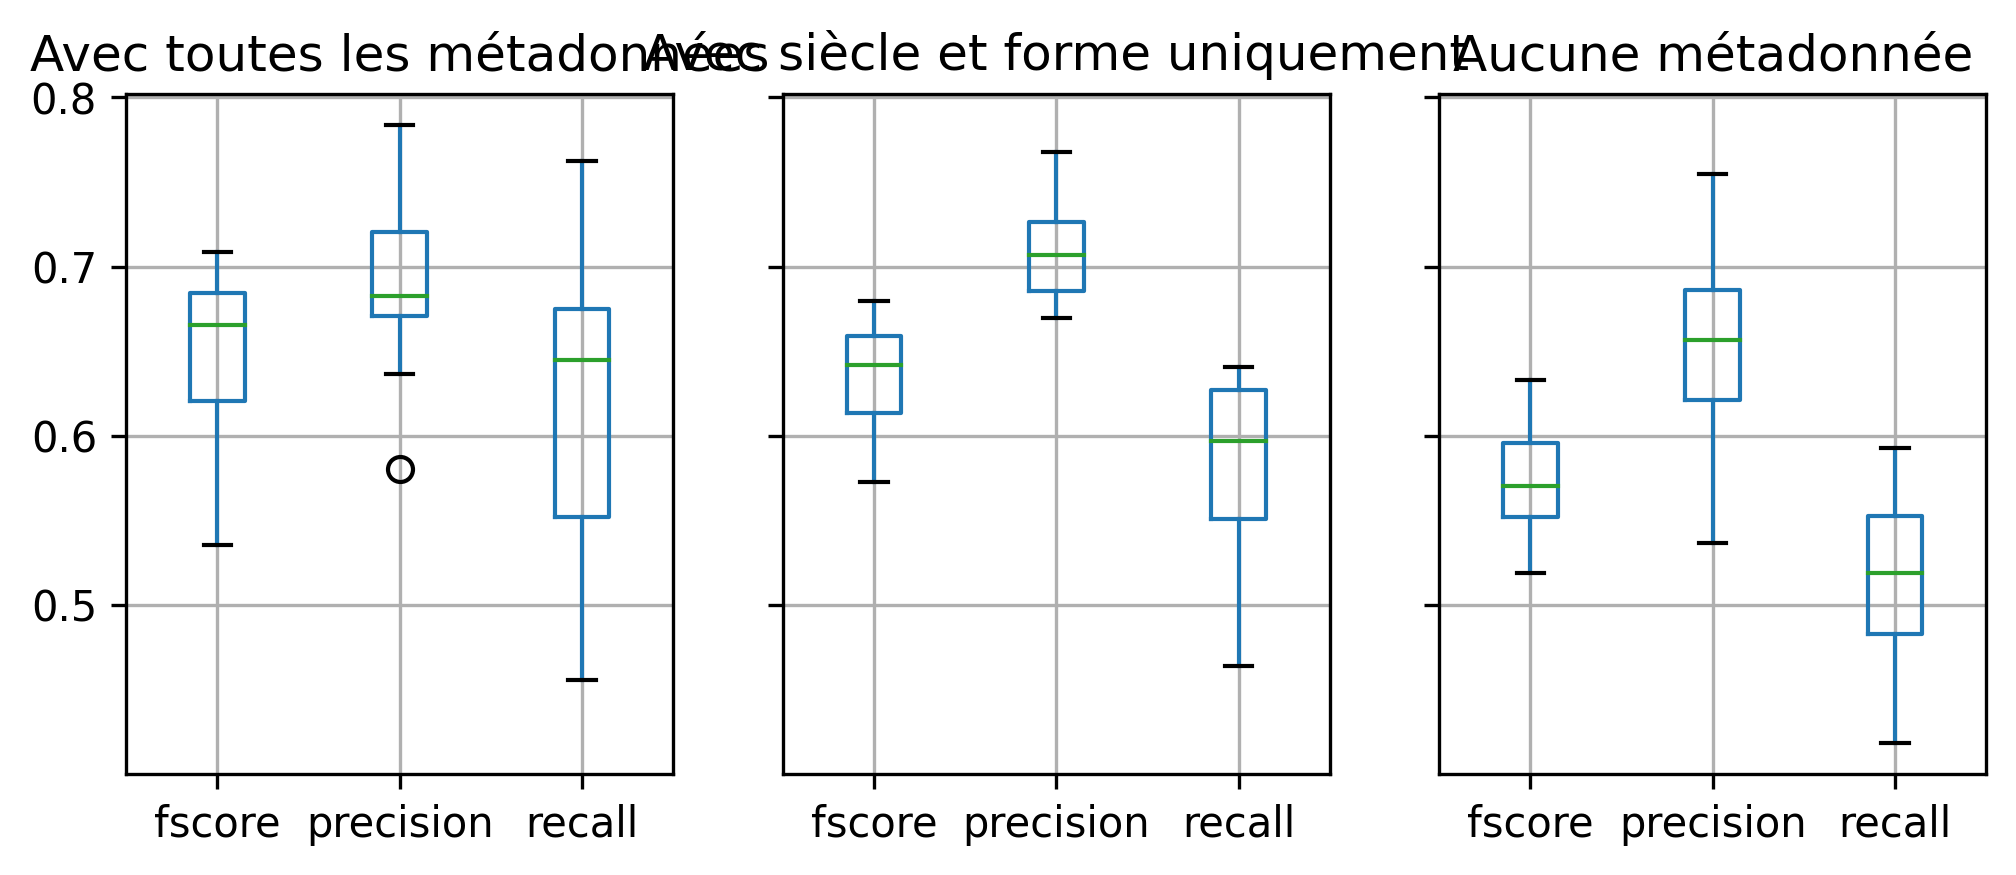

In [10]:
bests["no-metaphors"] = set(get((
    filtered["corpus"].str.contains("metaphors")
) & (
    filtered["corpus"].str.contains("inversed")
)))

## Partial

,model,fscore,fscore-positive,recall-positive,precision-positive,Enriched,MSD,Encoder,Metadata,Pretrained,Size,Method
11,LinearVanilla-NoMorph-HAN-LinearEnriched-Pretrained,0.840740,0.710579,0.709163,0.712000,Linear,,HAN,All,Word2Vec,256,Linear
45,LinearVanillaAggloMSD-EnriLSTM,0.840536,0.709278,0.685259,0.735043,LSTM,Agglo.,LSTM,All,,128,Linear
261,LinearVanilla-NoMorph-HAN-LinearEnriched-Pretrained,0.835798,0.700820,0.681275,0.721519,Linear,,HAN,All,Word2Vec,128,Linear
230,LinearVanillaAggloMSD-HAN-LinearEnriched-Pretrained-NoAuthor,0.835199,0.698947,0.661355,0.741071,Linear,Agglo.,HAN,"Form,Century,Citation",Word2Vec,128,Linear
193,LinearVanillaAggloMSD-EnriLSTM,0.832114,0.694045,0.673307,0.716102,LSTM,Agglo.,LSTM,All,,256,Linear


,model,fscore,fscore-positive,recall-positive,precision-positive,Enriched,MSD,Encoder,Metadata,Pretrained,Size,Method
189,LinearVanilla-NoMorph-HAN-LinearEnriched-Pretrained-NoAuthorCitation,0.819629,0.670833,0.641434,0.703057,Linear,,HAN,"Form,Century",Word2Vec,256,Linear
198,LinearVanilla-NoMorph-EnriLSTM-Pretrained-NoAuthorCitation-FastText,0.808718,0.653920,0.681275,0.628676,LSTM,,LSTM,"Form,Century",FastText,256,Linear
192,LinearVanilla-NoMorph-HAN-LinearEnriched-Pretrained-NoAuthorCitation,0.811423,0.652968,0.569721,0.764706,Linear,,HAN,"Form,Century",Word2Vec,128,Linear
70,LinearVanillaAggloMSD-HAN-LinearEnriched-Pretrained-NoAuthorCitation,0.810404,0.651786,0.581673,0.741117,Linear,Agglo.,HAN,"Form,Century",Word2Vec,128,Linear
222,LinearVanillaAggloMSD-EnriLSTM-Pretrained-NoAuthorCitation,0.796711,0.627451,0.573705,0.692308,LSTM,Agglo.,LSTM,"Form,Century",Word2Vec,256,Linear


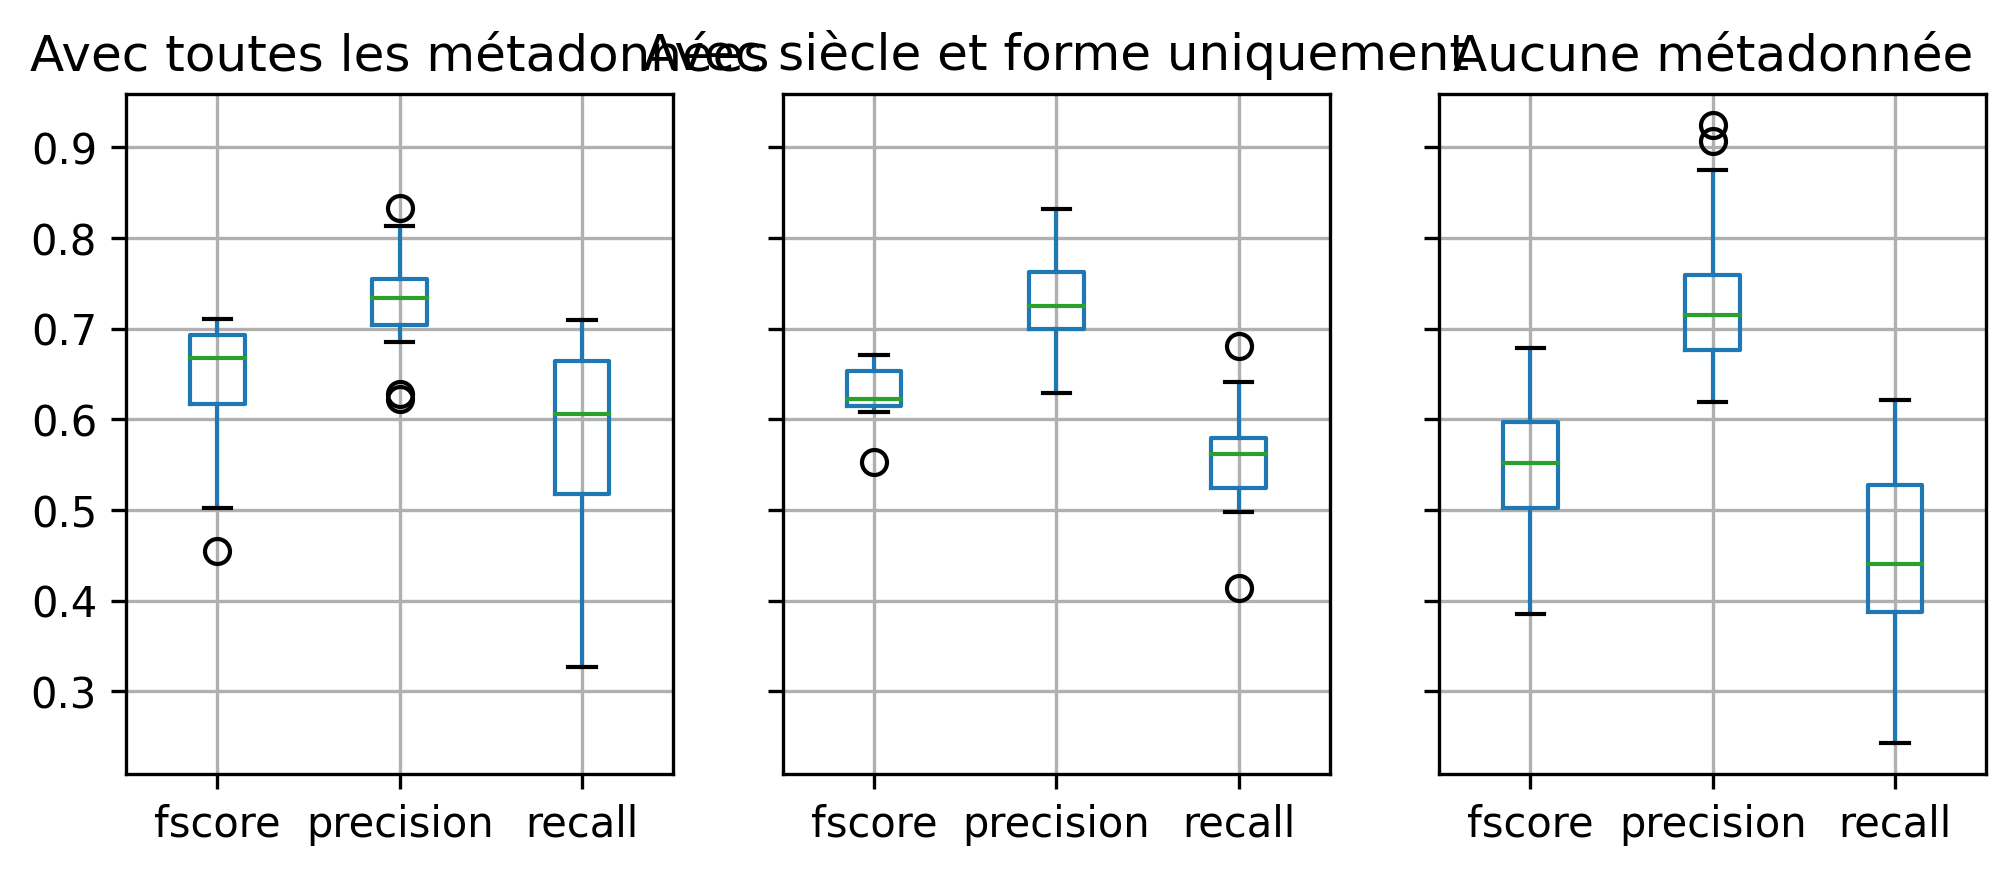

In [11]:
bests["partial"] = set(get(
    filtered["corpus"].str.contains("partial")
))

In [12]:
already_checked = []
from collections import Counter
top5 = Counter()
for key, sets in bests.items():
    for other_key, other_set in bests.items():
        if other_key != key and (key, other_key) not in already_checked:
            already_checked.append((key, other_key))
            already_checked.append((other_key, key))
            if sets.intersection(other_set):
                print(key, other_key, sets.intersection(other_set))
                top5 += Counter(sets.intersection(other_set))

                
display(HTML(
    pd.DataFrame(
        sorted(list(top5.items()), key=lambda x: x[-1]), columns=["Model", "Number of top n"]
    ).to_html(index=False)
))

main metaphors {'EnriLSTM-NoMSD-LSTM256-Form,Century-FastText-Linear', 'EnriLSTM-NoMSD-LSTM128-Form,Century-FastText-Linear', 'EnriLSTM-Agglo.-LSTM128-Form,Century-Word2Vec-Linear', 'EnriLSTM-Agglo.-LSTM256-Form,Century-Word2Vec-Linear', 'EnriLinear-NoMSD-HAN128-Form,Century-Word2Vec-Linear'}
main no-metaphors {'EnriLSTM-NoMSD-LSTM256-Form,Century-FastText-Linear', 'EnriLSTM-NoMSD-LSTM128-Form,Century-FastText-Linear', 'EnriLinear-NoMSD-HAN256-Form,Century-Word2Vec-Linear', 'EnriLSTM-NoMSD-LSTM128-Form,Century-Word2Vec-Linear', 'EnriLinear-Agglo.-HAN128-Form,Century-Word2Vec-Linear'}
main partial {'EnriLSTM-NoMSD-LSTM256-Form,Century-FastText-Linear', 'EnriLinear-NoMSD-HAN256-Form,Century-Word2Vec-Linear', 'EnriLSTM-Agglo.-LSTM256-Form,Century-Word2Vec-Linear', 'EnriLinear-NoMSD-HAN128-Form,Century-Word2Vec-Linear', 'EnriLinear-Agglo.-HAN128-Form,Century-Word2Vec-Linear'}
metaphors no-metaphors {'EnriLSTM-NoMSD-LSTM256-Form,Century-FastText-Linear', 'EnriLSTM-NoMSD-LSTM128-Form,Century

Model,Number of top n
"EnriLSTM-Agglo.-LSTM128-Form,Century-Word2Vec-Linear",1
"EnriLSTM-NoMSD-LSTM128-Form,Century-Word2Vec-Linear",1
"EnriLSTM-NoMSD-LSTM128-Form,Century-FastText-Linear",3
"EnriLSTM-Agglo.-LSTM256-Form,Century-Word2Vec-Linear",3
"EnriLinear-NoMSD-HAN128-Form,Century-Word2Vec-Linear",3
"EnriLinear-NoMSD-HAN256-Form,Century-Word2Vec-Linear",3
"EnriLinear-Agglo.-HAN128-Form,Century-Word2Vec-Linear",3
"EnriLSTM-NoMSD-LSTM256-Form,Century-FastText-Linear",6
